In [1]:
import torch
import numpy as np   

In [3]:
import sys
import os
sys.path.insert(0, "/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/")
print(sys.path)
from dataset.dataset_imputation import PRE8dDataset

['/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/', '/home/mafzhang/miniconda3/envs/torch/lib/python39.zip', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/mafzhang/.local/lib/python3.9/site-packages', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages']


In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='Chesapeake', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

In [4]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [5]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [6]:
model = torch.load("../../log/imputation/{}/GraphDiffusion/best_0.1.pt".format(config.area))
model = model.to(device)

In [7]:
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [8]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [9]:
from einops import rearrange
from model.dineof import DINEOF
is_sea = np.load("/home/mafzhang/data/{}/8d/is_sea.npy".format(config.area))
model = DINEOF(10, [is_sea.shape[0], is_sea.shape[1], config.in_len])
datas_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(132480, 3)
(132480,)


2024-09-20 19:27:21.915 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 139: 0.001328444387811178, 9.950295742758731e-06


In [10]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]

In [11]:
imputed_our = imputed_our[:1000]
imputed_dineof = imputed_dineof[:1000]
truth = truth[:1000]

PearsonRResult(statistic=0.9966300149037087, pvalue=0.0)
PearsonRResult(statistic=0.06366202127459077, pvalue=0.04414684778935579)


(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0')])

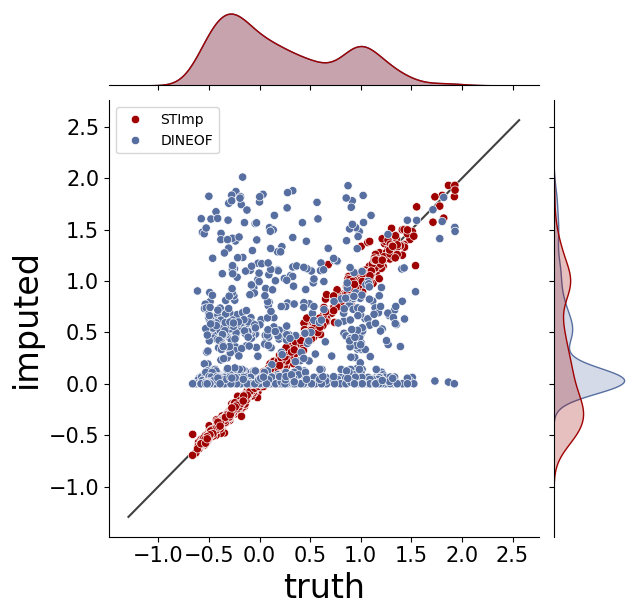

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STImp' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color, marginal_kws={'common_norm':False})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_dineof))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [13]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [14]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [15]:
model = torch.load("../../log/imputation/{}/GraphDiffusion/best_0.5.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [16]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [17]:
from einops import rearrange
from model.dineof import DINEOF
is_sea = np.load("/home/mafzhang/data/{}/8d/is_sea.npy".format(config.area))
model = DINEOF(10, [is_sea.shape[0], is_sea.shape[1], config.in_len])
datas_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(132480, 3)
(132480,)


2024-09-20 19:29:53.149 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 197: 0.001653590661754099, 9.984583112855952e-06


In [18]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]

In [19]:
imputed_our = imputed_our[:1000]
imputed_dineof = imputed_dineof[:1000]
truth = truth[:1000]

PearsonRResult(statistic=0.9918732963694639, pvalue=0.0)
PearsonRResult(statistic=0.005937363482162443, pvalue=0.8512507945549302)


(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

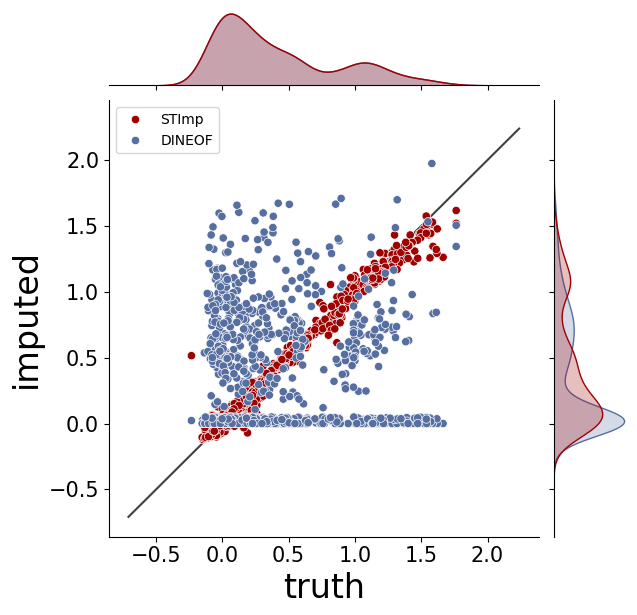

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STImp' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color, marginal_kws={'common_norm':False})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_dineof))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [22]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [23]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [24]:
model = torch.load("../../log/imputation/{}/GraphDiffusion/best_0.9.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [25]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [26]:
from einops import rearrange
from model.dineof import DINEOF
is_sea = np.load("/home/mafzhang/data/{}/8d/is_sea.npy".format(config.area))
model = DINEOF(10, [is_sea.shape[0], is_sea.shape[1], config.in_len])
datas_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,is_sea.shape[0],is_sea.shape[1])
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(132480, 3)
(132480,)


2024-09-20 19:30:53.505 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 90: 0.0006858107300709615, 9.97647038320827e-06


In [27]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]

In [28]:
imputed_our = imputed_our[:1000]
imputed_dineof = imputed_dineof[:1000]
truth = truth[:1000]

PearsonRResult(statistic=0.9769265411261869, pvalue=0.0)
PearsonRResult(statistic=-0.035738005544450835, pvalue=0.2588631739612502)


(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

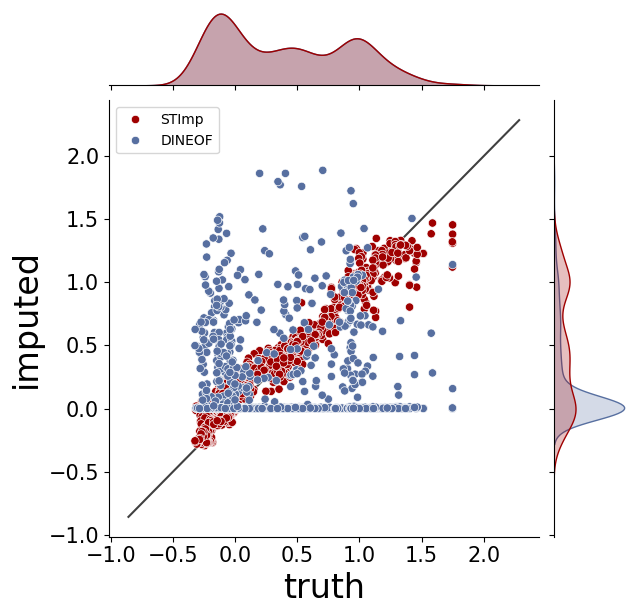

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STImp' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color, marginal_kws={'common_norm':False})
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_dineof))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [23]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)

In [24]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [25]:
model = torch.load("../../log/imputation/PRE/GraphDiffusion/best_0.1.pt")
model = model.to(device)

In [26]:
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [27]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
truth = datas[0]
truth[~data_ob_masks[0].bool()]=np.nan

In [28]:
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len])
is_sea = np.load("/home/mafzhang/data/PRE/8d/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = torch.where(ob_mask_image.cpu()==0, float("nan"), tmp_data)
tmp_data = rearrange(tmp_data, "b t c h w -> (b h w c t)")
tmp_data = tmp_data.cpu().numpy()
time = torch.arange(datas_image.shape[1]).unsqueeze(0).unsqueeze(0).expand(datas_image.shape[-2], datas_image.shape[-1], -1).reshape(-1)
lati = torch.arange(datas_image.shape[-2]).unsqueeze(-1).unsqueeze(-1).expand(-1, datas_image.shape[-1], datas_image.shape[1]).reshape(-1)
lon = torch.arange(datas_image.shape[-1]).unsqueeze(0).unsqueeze(-1).expand(datas_image.shape[-2], -1, datas_image.shape[1]).reshape(-1)
x = np.stack([lati.numpy(), lon.numpy(), time.numpy()], axis=1)
print(x.shape)
print(tmp_data.shape)
model.fit(x, tmp_data)

imputed_data = model.predict(x)
imputed_data = rearrange(imputed_data, "(b t c h w)->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

(264960, 3)
(264960,)


2024-09-19 15:26:25.695 | INFO     | model.dineof:_fit:104 - Error/Relative Error at iteraion 148: 0.002043189416349539, 9.98965447650919e-06


In [29]:
imputed_dineof = imputed_data[0,:,0]

In [30]:
imputed_stimp = torch.zeros(46,60,96)
imputed_stimp[:,is_sea.astype(bool)]=imputed_data_our[0,:,0]
observed = torch.zeros(46,60,96)
observed[:,is_sea.astype(bool)]=truth.cpu().squeeze()

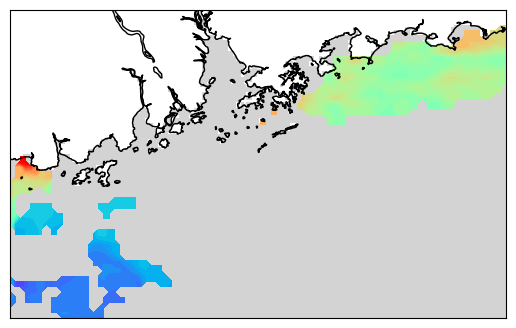

In [31]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

t=0
is_sea2=np.load("/home/mafzhang/data/PRE/8d/is_sea_2.npy")
tmp = deepcopy(observed[t].numpy())
tmp[~is_sea2.astype(bool)]= np.nan
raw_data = h5py.File("/home/mafzhang/data/PRE/8d/modis_chla_8d_4km_pre.mat", 'r')
lon = np.array(raw_data['longitude']).squeeze()
lati = np.array(raw_data['latitude']).squeeze()

[x,y] = meshgrid(lon, lati)


lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
# map.fillcontinents(color='white')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

# map.contourf(x, y, tmp2, levels=np.linspace(-1.5, 1.5, 40),cmap="Greys")
# map.colorbar(boundaries=np.linspace(-1.5, 1.5, 20), ticks=np.linspace(-1.5, 1.5, 6))

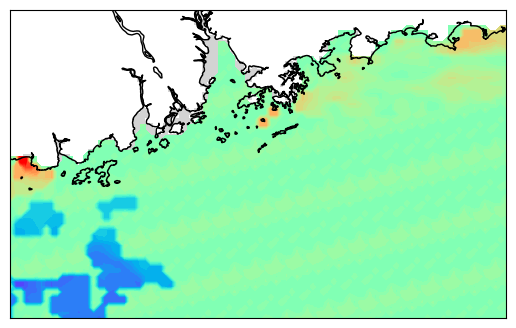

In [33]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

t=0
tmp = deepcopy(imputed_dineof[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea2.astype(bool)]= np.nan

lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

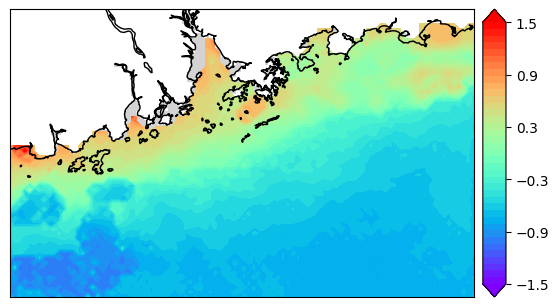

In [34]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

t=0
tmp = deepcopy(imputed_stimp[t].numpy())
tmp[~is_sea2.astype(bool)]= np.nan

[x,y] = meshgrid(lon, lati)


lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
# map.fillcontinents(color='white')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

# map.contourf(x, y, tmp2, levels=np.linspace(-1.5, 1.5, 40),cmap="Greys")
map.colorbar(boundaries=np.linspace(-1.5, 1.5, 20), ticks=np.linspace(-1.5, 1.5, 6))

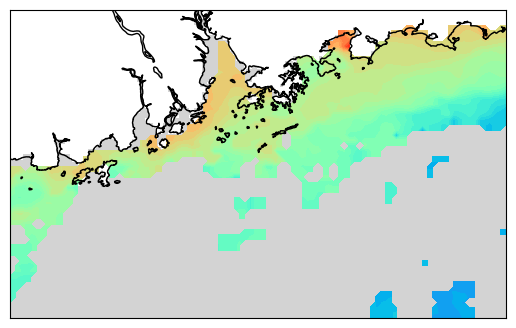

In [37]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

t=13
tmp = deepcopy(observed[t].numpy())
tmp[~is_sea2.astype(bool)]= np.nan
raw_data = h5py.File("/home/mafzhang/data/PRE/8d/modis_chla_8d_4km_pre.mat", 'r')
lon = np.array(raw_data['longitude']).squeeze()
lati = np.array(raw_data['latitude']).squeeze()

[x,y] = meshgrid(lon, lati)


lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
# map.fillcontinents(color='white')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

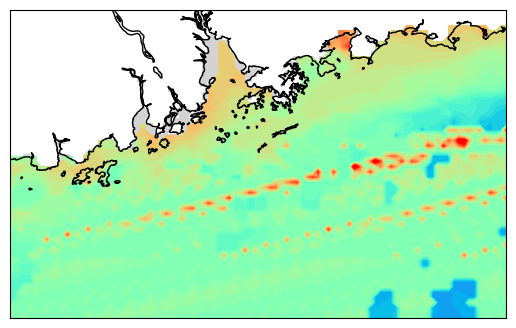

In [38]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

tmp = deepcopy(imputed_dineof[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea2.astype(bool)]= np.nan

lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

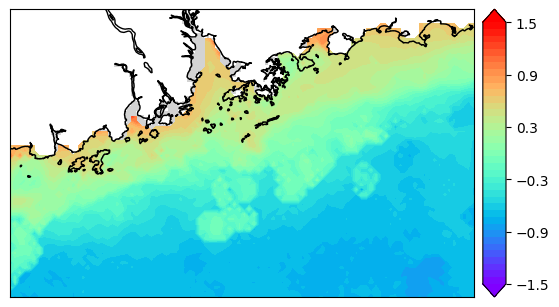

In [40]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

tmp = deepcopy(imputed_stimp[t].numpy())
tmp[~is_sea2.astype(bool)]= np.nan

[x,y] = meshgrid(lon, lati)


lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
# map.fillcontinents(color='white')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

# map.contourf(x, y, tmp2, levels=np.linspace(-1.5, 1.5, 40),cmap="Greys")
map.colorbar(boundaries=np.linspace(-1.5, 1.5, 20), ticks=np.linspace(-1.5, 1.5, 6))

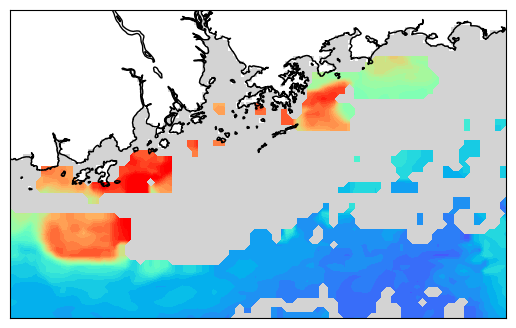

In [42]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

t=37
tmp = deepcopy(observed[t].numpy())
tmp[~is_sea2.astype(bool)]= np.nan
raw_data = h5py.File("/home/mafzhang/data/PRE/8d/modis_chla_8d_4km_pre.mat", 'r')
lon = np.array(raw_data['longitude']).squeeze()
lati = np.array(raw_data['latitude']).squeeze()

[x,y] = meshgrid(lon, lati)


lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
# map.fillcontinents(color='white')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

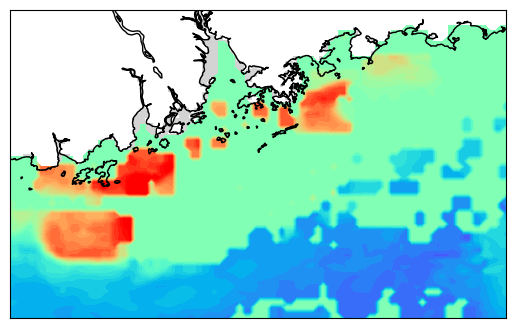

In [43]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

tmp = deepcopy(imputed_dineof[t])
mask = np.zeros_like(tmp)
mask[is_sea.astype(bool)]=data_ob_masks[0,t,0].cpu()
tmp = np.where(mask, observed[t].numpy(), tmp)
tmp[~is_sea2.astype(bool)]= np.nan

lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

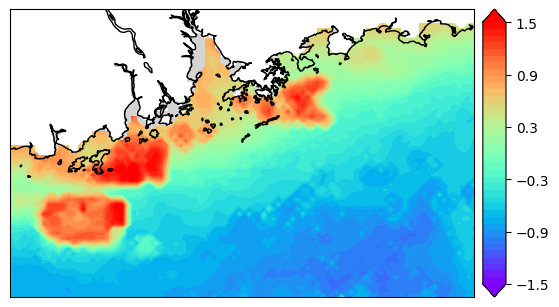

In [44]:
from mpl_toolkits import basemap
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import cartopy.crs as ccrs
from copy import deepcopy
import h5py
from numpy import meshgrid
import numpy as np

tmp = deepcopy(imputed_stimp[t].numpy())
tmp[~is_sea2.astype(bool)]= np.nan

[x,y] = meshgrid(lon, lati)


lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='f')
# map.fillcontinents(color='white')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
# map.bluemarble()
map.drawcoastlines()
map.contourf(x, y, tmp, levels=np.linspace(-1.5, 1.5, 40),cmap="rainbow",extend='both')

# map.contourf(x, y, tmp2, levels=np.linspace(-1.5, 1.5, 40),cmap="Greys")
map.colorbar(boundaries=np.linspace(-1.5, 1.5, 20), ticks=np.linspace(-1.5, 1.5, 6))